# Replicating Carpenter and Dobkin's 2015 Study

# The Minimum Legal Drinking Age and Crime

## Introduction

Study's Abstract:

"We use variation from the minimum legal drinking age to estimate the causal effect of access to alcohol on crime. Using a census of arrests in California and a regression discontinuity design, we find that individuals just over age 21 are 5.9% more likely to be arrested than individuals just under 21. This increase is mostly due to assaults, alcohol-related offenses, and nuisance crimes. These results suggest that policies that restrict access to alcohol have the potential to substantially reduce crime."

I am replicating this paper to showcase my understanding of the Regression Discontinuity design (RD).

Applied Econometrics methods are always trying to exploit quasi-experiments to identify a treatment and control group and measure the Average Treatment Effect (ATE) of a given phenomena as pure experiments that assign treatment randomly are had to find/do. RD attempts to do this by exploiting scenarios where treatment is assigned at a cutoff above or below a continuous running variable. A famous example is using merit based scholarship awarded to students when a threshold is met on their SAT scores to study the impact of the scholarship on their future outcomes. The idea is that the running variable should have a smooth association with the outcome variable so that a significant discontinuous shock occurs at the threshold could be considered a treatment effect. It is compared to seeing a turtle on a fencepost. We know turtles can cross distances naturally, gradually. But, we know that turtles getting on top of the fence post cannot occur naturally. Someone put it there (i.e. treatment). Another angle to view this is that the object of study cannot select into treatment and thereby bias our measure of casual inference (selection bias). Another example is they cutoff of at the age of 21 for drinking int the U.S. People will age, but they cannot choose their age.

The basic model is:

$Y_{i} = \alpha + \beta_{1}$running_variable$_{i} + \beta_{2}$post_threshold_dummy$_{i} + e_{i}$

One could also add qaudratic or cubic terms to allow for nonlinear trends in the running variable and then add interaction with those terms and the post threshold dummy variable to allow for trends to differ below and above the cutoff. Additionally, covariates can be added to account for other confounders. More can be explained here:

https://mixtape.scunning.com/regression-discontinuity.html

Before proceeding, its important to explain that the running variable's duration is typically shortened to keep differring moments in the trend that occur further off from the cutoff from biasing the estimated impact at the cutoff. There is a trade off to restricting the running variable is that we lose variation in our data and thereby increase our standard errors, making it harder to claim that our estimates are statistcally different from zero. In this paper, the authors reduced the running variable Age to 2 years on either side of of 21.

In [1]:
import os
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
from stargazer.stargazer import Stargazer
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Removes the limit from the number of displayed columns and rows.
#This is so I can see the entire dataframe when I print it
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

In [3]:
df = pd.read_stata('P01 Age Profile of Arrest Rates 1979-2006.dta')
#Dimensions of df
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns.')
df.tail(15)

The dataset has 2922 rows and 143 columns.


,days_to_21,all,felony,misdemeanor,fbi_offense_miss,violent,murder,manslaughter,rape,robbery,assault,aggravated_assault,ot_assault,property,burglary,larceny,mv_theft,stolen_prop_buy_rec_poss,vandalism,ill_drugs,cocaine_opio_sale_manuf,mj_sale_manuf,dang_non_narc_sale_manuf,cocaine_opio_posses,mj_posses,dang_non_narc_posses,alcohol,drunk_at_risk,dui,liquor_laws,drunkeness_pc,disorderly_cond,vagrancy,fbi_other,arson,forgery_counterfit,fraud,embezelment,weapons,prostitution,sex_offenses,bookmaking,all_other_gambling,aga_family_child,curfew_loitering,runaways,coded_on_offense,county_ordinance,outside_warrent,traffic_violations,hit_run_reckl_driv,parole_violation,dump_or_litter,trespass,violate_court_order,failure_to_appear,cont_delinq_minor,not_classified,other_reported,pop1,pop2,pop3,pop_day1,pop_day2,pop_day3,years_to_21,yrs_to_21_month,yrs_to_21_fortnight,post,linear,square,cubic,linear_post,square_post,cubic_post,birthday_19,birthday_19_1,birthday_20,birthday_20_1,birthday_21,birthday_21_1,birthday_22,birthday_22_1,birthday_23,birthday_23_1,ill_drugs_r,cocaine_opio_sale_manuf_r,mj_sale_manuf_r,dang_non_narc_sale_manuf_r,cocaine_opio_posses_r,mj_posses_r,dang_non_narc_posses_r,dui_r,liquor_laws_r,drunkeness_pc_r,felony_r,misdemeanor_r,violent_r,murder_r,manslaughter_r,rape_r,robbery_r,assault_r,aggravated_assault_r,ot_assault_r,property_r,burglary_r,larceny_r,mv_theft_r,stolen_prop_buy_rec_poss_r,vandalism_r,disorderly_cond_r,vagrancy_r,fbi_other_r,arson_r,forgery_counterfit_r,fraud_r,embezelment_r,weapons_r,prostitution_r,sex_offenses_r,bookmaking_r,all_other_gambling_r,aga_family_child_r,curfew_loitering_r,runaways_r,county_ordinance_r,traffic_violations_r,hit_run_reckl_driv_r,dump_or_litter_r,trespass_r,violate_court_order_r,failure_to_appear_r,cont_delinq_minor_r,not_classified_r,drunk_at_risk_r,outside_warrent_r,parole_violation_r,other_reported_r,coded_on_offense_r,alcohol_r,all_r,other_r
2907,1446.0,4802.0,1433.0,3369.0,575.0,551.0,8.0,1.0,17.0,64.0,461.0,282.0,179.0,569.0,154.0,234.0,63.0,77.0,41.0,750.0,81.0,43.0,40.0,278.0,119.0,189.0,1422.0,6.0,921.0,38.0,419.0,31.0,13.0,300.0,3.0,44.0,33.0,9.0,87.0,73.0,44.0,1.0,1.0,5.0,0.0,0.0,1057.0,171.0,91.0,420.0,51.0,6.0,11.0,33.0,23.0,247.0,4.0,153.0,287.0,1.381757e+07,13253499.0,2.995525e+06,37856.357583,36310.956164,8206.918251,3.961644,24.986301,24.969863,1.0,3.961644,15.694622,62.176502,3.961644,15.694622,62.176502,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,198.117317,21.396670,11.358726,10.566257,73.435486,31.434614,49.925564,243.288065,10.037944,110.681541,394.646727,927.819137,151.744834,2.203192,0.275399,4.681783,17.625534,126.958926,77.662510,49.296416,156.702015,42.411442,64.443359,17.350135,21.205721,11.291358,8.537368,3.580187,82.619692,0.826197,12.117555,9.088166,2.478591,23.959711,20.104125,12.117555,0.275399,0.275399,1.376995,0.0,0.0,47.093224,115.667568,14.045348,3.029389,9.088166,6.334176,68.023546,1.101596,42.136043,7.310905,110.882060,7.310905,349.704958,382.575978,383.436010,1397.331888,507.331712
2908,1447.0,4636.0,1357.0,3279.0,521.0,501.0,6.0,2.0,15.0,66.0,412.0,229.0,183.0,609.0,155.0,269.0,79.0,67.0,39.0,701.0,68.0,46.0,52.0,245.0,111.0,179.0,1384.0,3.0,897.0,24.0,420.0,30.0,13.0,233.0,2.0,37.0,30.0,4.0,68.0,55.0,36.0,0.0,0.0,1.0,0.0,0.0,1042.0,157.0,85.0,376.0,54.0,8.0,15.0,45.0,22.0,277.0,3.0,166.0,241.0,1.381789e+07,13253763.0,2.995463e+06,37857.243783,36311.679452,8206.748944,3.964384,24.986301,24.969863,1.0,3.964384,15.716337,62.305588,3.964384,15.716337,62.305588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,185.169318,17.962216,12.150911,13.735812,64.716809,29.320677,47.282893,236.942765,6.339606,110.943100,373.708961,903.015242,137.972137,1.652361,0.550787,4.130902,18.175970,113.462116,63.065108,50.397008,167.714633,42.685990,74.080848,21.756085,18.451364,10.740346,8.261805,3.580115,64.166682,0.550787,10.189559,8.261805,1.101574,18.726757,15.146642,9.914166,0.000000,0.000000,0.275393,0.0,0.0,43.236777,103.547951,14.871248,4.130902,12.392707,6.058657,76

## Data

The dataset consists observations based on the age (in days) of individuals at the time that they were arrested in California from 1979 to 2006. So that each row is the aggregated arrest rate per 10,000 person-years for people at each age in days. The dataset provided includes many variables that have already been transformed by the authors. 

The variables 'days_to_21', 'years_to_21', and 'yrs_to_21_month' are all the age at each observation  at each granularity minus 21. This differencing is done to center the running variable at the cutoff. The variable 'linear' is the same as years_to_21 while 'sqaure' is 'linear'^2 and 'cubic' is 'linear'^3. Interation terms are included for each alternative running variable term and cutoff dummy variable, such as 'linear_post' and 'square_post'.

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
days_to_21,2922.0,-0.500000,843.653069,-1461.000000,-730.750000,-0.500000,729.750000,1460.000000
all,2922.0,5057.746407,362.257589,4123.000000,4778.250000,5160.500000,5335.000000,7850.000000
felony,2922.0,1527.501711,127.832595,1250.000000,1426.000000,1514.000000,1624.000000,1949.000000
misdemeanor,2922.0,3474.674880,404.947802,2379.000000,3365.000000,3616.000000,3731.000000,6059.000000
fbi_offense_miss,2922.0,529.619097,141.896842,159.000000,517.000000,585.000000,621.000000,778.000000
...,...,...,...,...,...,...,...,...
other_reported_r,2922.0,271.451388,70.885639,80.741569,238.013312,297.975738,321.955772,405.833736
coded_on_offense_r,2922.0,371.752555,96.076196,133.717811,360.994040,407.181251,432.958613,577.326259
alcohol_r,2922.0,359.996477,69.834805,159.213516,358.407202,384.534614,399.035722,904.338621
all_r,2922.0,1489.652725,111.427911,1210.067842,1398.102253,1519.987992,1577.947426,2307.345976


## Replicating Figure 1

The graph below was made by grouping the 'days_to_21' in 2 week long bins and then taking the average of each crime category for each bin and plotting a trend line along with the averages.

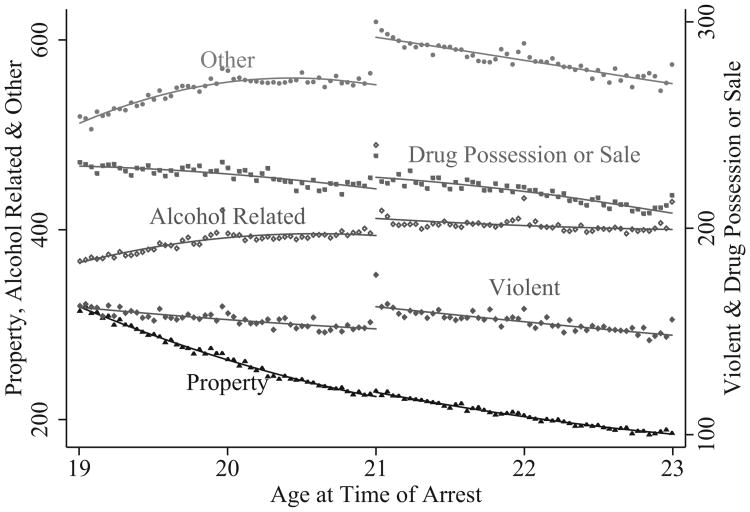

In [5]:
df2 = df[df['days_to_21'].between(-2*364,2*365)] # Limiting the data to 2 years on both sides of the cutoff
# Below categorizes the data into groups based on two week increments
df2['14days'] =  df2.days_to_21.divide(other=14).apply(lambda x:math.floor(x)) 
# Below collapses the data into these groups
df3 = pd.pivot_table(df2,columns='14days').T.reset_index()

In [8]:
def set_size(w,h, ax=None):
    """ 
    This function adjustes the size of the graph it is applied to.
    w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)
    
# This function helps streamline the code to build the OLS model
def build_ols_model(dep,ind):
    # Create the model
    olsmodel = sm.OLS(dep,ind, missing='drop')
    return olsmodel.fit(cov_type='HC1')

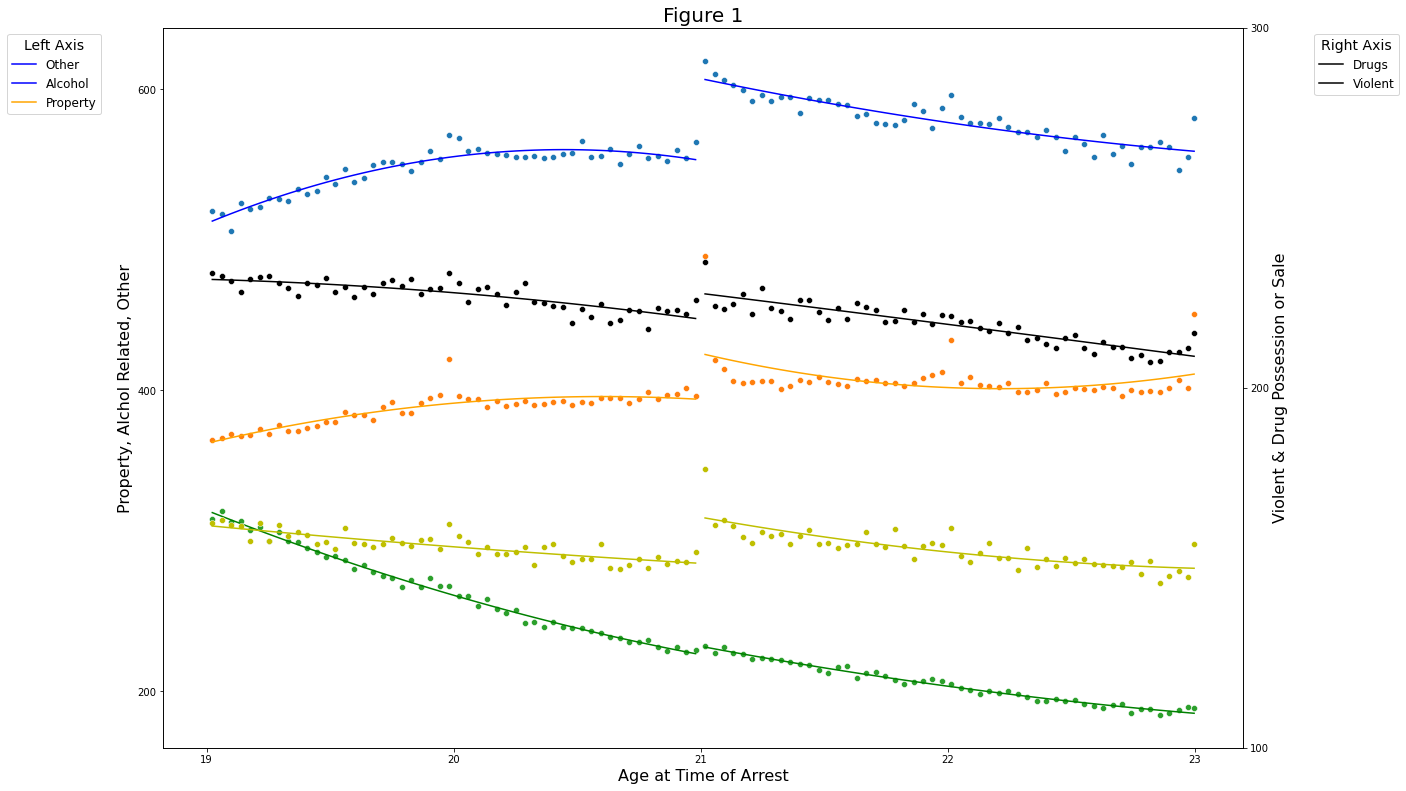

In [17]:
df3['age'] = df3['linear']+21 # Calculating age by adding 21 (center of original var) to linear var
df3 = sm.add_constant(df3) # Adding constant term for regressing the trends
Xu21 = df3.loc[df3['age']<=21,['const','linear', 'square']] # Ind vars for before cutoff
Xa21 = df3.loc[df3['age']>21,['const','linear', 'square']] # Ind vars for after cutoff
yu21 = df3.loc[df3['age']<=21,['other_r','alcohol_r','property_r','ill_drugs_r','violent_r']] # Dep vars for before cutoff
ya21 = df3.loc[df3['age']>21,['other_r','alcohol_r','property_r','ill_drugs_r','violent_r']] # Dep vars for after cutoff



# Plotting trend lines for vars using the left hand axis
ax= df3.assign(predictions=build_ols_model(yu21.iloc[:,0], Xu21).fittedvalues).plot(x="age", y="predictions",  color="b")
df3.assign(predictions=build_ols_model(ya21.iloc[:,0], Xa21).fittedvalues).plot(x="age", y="predictions",  color="b",ax=ax)
df3.assign(predictions=build_ols_model(yu21.iloc[:,1], Xu21).fittedvalues).plot(x="age", y="predictions",  color="orange",ax=ax)
df3.assign(predictions=build_ols_model(ya21.iloc[:,1], Xa21).fittedvalues).plot(x="age", y="predictions",  color="orange",ax=ax)
df3.assign(predictions=build_ols_model(yu21.iloc[:,2], Xu21).fittedvalues).plot(x="age", y="predictions",  color="g",ax=ax)
df3.assign(predictions=build_ols_model(ya21.iloc[:,2], Xa21).fittedvalues).plot(x="age", y="predictions",  color="g",ax=ax)

set_size(15,10) # Setting size of the graph

# Plotting binned means for vars using the left hand axis
sns.scatterplot(df3.age, df3['other_r'],ax=ax)
sns.scatterplot(df3.age, df3['alcohol_r'],ax=ax)
sns.scatterplot(df3.age, df3['property_r'],ax=ax)
ax.legend(labels=['Other','Alcohol','Property'], loc = 2, bbox_to_anchor = (-0.15,1), 
           fontsize=12, title='Left Axis', title_fontsize=14)
ax.set_title('Figure 1', fontsize=20)
ax.set_yticks(np.arange(200,800,200))
ax.set_xticks(np.arange(19, 24, 1))
ax.set_xlabel('Age at Time of Arrest', fontsize=16)
ax.set_ylabel('Property, Alchol Related, Other', fontsize=16)
ax2 = ax.twinx()

# Plotting trend lines for vars using the right hand axis
df3.assign(predictions=build_ols_model(yu21.iloc[:,3], Xu21).fittedvalues).plot(x="age", y="predictions",  color="black",ax=ax2)
df3.assign(predictions=build_ols_model(ya21.iloc[:,3], Xa21).fittedvalues).plot(x="age", y="predictions",  color="black",ax=ax2)
df3.assign(predictions=build_ols_model(yu21.iloc[:,4], Xu21).fittedvalues).plot(x="age", y="predictions",  color="y",ax=ax2)
df3.assign(predictions=build_ols_model(ya21.iloc[:,4], Xa21).fittedvalues).plot(x="age", y="predictions",  color="y",ax=ax2)

# Plotting binned means for vars using the right hand axis
sns.scatterplot(df3.years_to_21+21, df3['ill_drugs_r'],color='black', ax=ax2)
sns.scatterplot(df3.years_to_21+21, df3['violent_r'],color='y', ax=ax2)

ax2.set(ylim=(100, 300))
ax2.set_yticks(np.arange(100,400,100))
ax2.set_ylabel('Violent & Drug Possession or Sale', fontsize=16)
ax2.legend(labels=['Drugs', 'Violent'],loc = 1,bbox_to_anchor = (1.15,1), 
           fontsize=12, title='Right Axis', title_fontsize=14)

### Observations
- The replication is essentially identical with the exception of the post-threshold trend for alcohol related crimes.
- I am having issues with the legend. This problem only occurs when I include the trends.

## Replication of Table 1

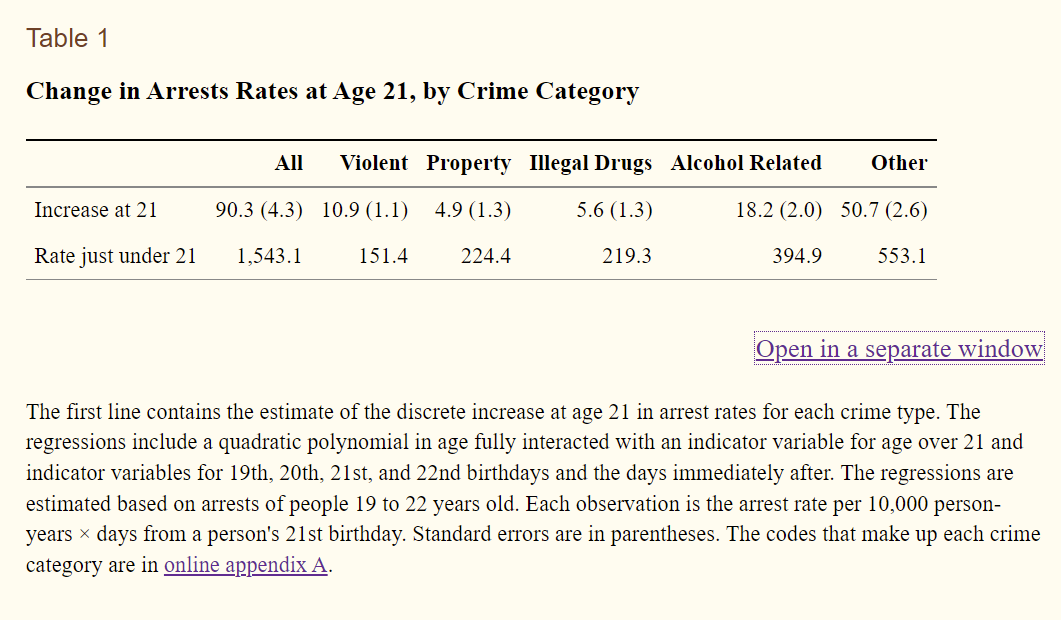

In [39]:
# Took some meddling to figure out that the right tail of the running var was multiplied by 364, not 365
df4 = df[df['days_to_21'].between(-2*365,2*364)] 
X=df4[['linear', 'square','post','linear_post', 'square_post','birthday_19','birthday_19_1','birthday_20','birthday_20_1',
      'birthday_21','birthday_21_1','birthday_22','birthday_22_1','birthday_23', 'birthday_23_1']]
X = sm.add_constant(X)

y= df4[['all_r','violent_r','property_r','ill_drugs_r','alcohol_r','other_r']]


ADmodel = build_ols_model(y['all_r'], X)
Vmodel = build_ols_model(y['violent_r'], X)
Pmodel = build_ols_model(y['property_r'], X)
Dmodel = build_ols_model(y['ill_drugs_r'], X)
ALmodel = build_ols_model(y['alcohol_r'], X)
Omodel = build_ols_model(y['other_r'], X)

# Calculates the discontinuity of the running var's association with the dep var at the threshold
print('Spike in total crimes:', round(ADmodel.params['post']/ADmodel.params['const']*100,2),'%')
print('Spike in violent crimes:', round(Vmodel.params['post']/Vmodel.params['const']*100,2),'%')
print('Spike in property crimes:', round(Pmodel.params['post']/Pmodel.params['const']*100,2),'%')
print('Spike in illegal drug crimes:', round(Dmodel.params['post']/Dmodel.params['const']*100,2),'%')
print('Spike in alcohol crimes:', round(ALmodel.params['post']/ALmodel.params['const']*100,2),'%')
print('Spike in other crimes:', round(Omodel.params['post']/Omodel.params['const']*100,2),'%')

# Comparison Table
comparison = Stargazer([ADmodel, Vmodel,Pmodel, Dmodel,ALmodel,Omodel])
comparison.title('Table1 Change in Arrests Rates at Age 21, by Crime Category')
comparison.covariate_order(['post','const'])
comparison.rename_covariates({'post': 'Increase at 21','const':'Rate just under 21'})
comparison.custom_columns(['All', 'Violent','Property','Illegal Drugs', 'Alcohol Related','Other'], [1, 1, 1, 1, 1, 1])
comparison.show_model_numbers(False)
comparison.significant_digits(1)
comparison.show_degrees_of_freedom(False)
comparison

Spike in total crimes: 5.85 %
Spike in violent crimes: 7.19 %
Spike in property crimes: 2.19 %
Spike in illegal drug crimes: 2.55 %
Spike in alcohol crimes: 4.59 %
Spike in other crimes: 9.16 %


### Observations
- For each model, both estimated coefficients of interest were statistically significant. 
- Of the subcategories, the largest impact was on 'Other' crimes, followed by a distant impact on 'Violent' crimes.
- There are two slight different estimates, a tenth off, for 'All' and "Alcohol Related' crimes at the cutoff.

# References

Carpenter, C., & Dobkin, C. (2015). The Minimum Legal Drinking Age and Crime. The review of economics and statistics, 97(2), 521–524. https://doi.org/10.1162/REST_a_00489

Carpenter, Christopher; Dobkin, Carlos, 2014, "Replication data for: The Minimum Legal Drinking Age and Crime", https://doi.org/10.7910/DVN/27070, Harvard Dataverse, V1

Cunningham, Scott. Causal Inference: The Mixtape, 13 Sept. 2021, https://mixtape.scunning.com/introduction.html. 